<a href="https://colab.research.google.com/github/rihat99/openai_gym/blob/main/CartPole_PolicyGradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

import gym

env = gym.make('CartPole-v1')

!python --version
print(tf.__version__)
print(gym.__version__)

Python 3.7.10
2.4.1
0.17.3


In [2]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

Size of State Space ->  4
Size of Action Space ->  2


In [3]:
def PolicyNetwork():
    input_states = keras.layers.Input(shape=[num_states])
    hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
    #hidden1 = keras.layers.Dropout(0.1)(hidden1)
    hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
    #hidden2 = keras.layers.Dropout(0.1)(hidden2)
    probs = keras.layers.Dense(num_actions, activation='softmax')(hidden2)
    model = keras.Model(inputs=[input_states], outputs=[probs])
    return model

In [4]:
def DiscountRewards(rewards, gamma):
    sum_reward = 0
    discounted_rewards = []
    rewards.reverse()
    for r in rewards:
        sum_reward = r + gamma*sum_reward
        discounted_rewards.append(sum_reward)
    discounted_rewards.reverse()
    discounted_rewards = np.array(discounted_rewards)
    mean = np.mean(discounted_rewards)
    std = np.std(discounted_rewards)
    return (discounted_rewards - mean) / (std+1e-9)
    # return discounted_rewards

In [9]:
# Discount factor for future rewards
gamma = 0.97
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(lr)
model = PolicyNetwork()

total_episodes = 3000


from IPython.display import clear_output
ep_reward_list = []
avg_reward_list = []
best_score = -200
best_weights = model.get_weights()

Episode: 572 Current Reward: 500.0
Average_reward:  482.525


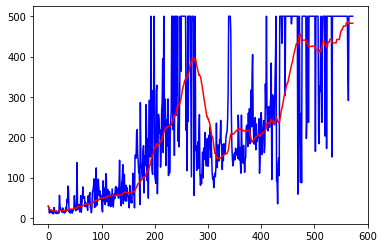

KeyboardInterrupt: ignored

In [10]:
for ep in range(total_episodes):
    prev_state = env.reset()
    episodic_reward = 0
    step = 0
    reward_history = []
    action_history = []
    state_history = []

    while True:
        probs = model(prev_state[np.newaxis])[0]
        #action = np.random.choice(num_actions, p=np.squeeze(probs))
        dist = tfp.distributions.Categorical(probs=probs)
        action = dist.sample()
        state, reward, done, info = env.step(int(action))
        reward_history.append(reward)
        action_history.append(action)
        state_history.append(prev_state)
        episodic_reward += reward

        if done:
            break
        prev_state = state
        step += 1

    discounted_rewards = DiscountRewards(reward_history, gamma)
    for reward, action, state in zip(discounted_rewards, action_history, state_history):
        with tf.GradientTape() as tape:
            probs = model(state[np.newaxis])[0]
            dist = tfp.distributions.Categorical(probs=probs)
            log_prob = dist.log_prob(action)
            loss = -(reward * log_prob)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    clear_output(wait=True)
    print('Episode:', ep, 'Current Reward:', episodic_reward)
    print('Average_reward: ', avg_reward)
    if avg_reward > best_score:
        best_weights = model.get_weights()
        best_score = avg_reward
    plt.plot(np.arange(len(ep_reward_list)),ep_reward_list, 'b',
             np.arange(len(avg_reward_list)), avg_reward_list, 'r')
    plt.show()

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

from colabgymrender.recorder import Recorder

directory = './video'
video_env = Recorder(env, directory)

In [13]:
obs = video_env.reset()
while True:
    action = np.argmax(model(obs[np.newaxis])[0])
    obs, reward, done, info = video_env.step(action)
    if done:
        break

video_env.play()

100%|█████████▉| 501/502 [00:01<00:00, 296.21it/s]
